In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
#from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table

# Data

In [222]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   Value of House  1000 non-null   float64
 2   TAX             1000 non-null   int64  
 3   LOT SQFT        1000 non-null   int64  
 4   YR BUILT        1000 non-null   int64  
 5   GROSS AREA      1000 non-null   int64  
 6   LIVING AREA     1000 non-null   int64  
 7   FLOORS          1000 non-null   float64
 8   ROOMS           1000 non-null   int64  
 9   BEDROOMS        1000 non-null   int64  
 10  FULL BATH       1000 non-null   int64  
 11  HALF BATH       1000 non-null   int64  
 12  KITCHEN         1000 non-null   int64  
 13  FIREPLACE       1000 non-null   int64  
 14  REMODEL         1000 non-null   object 
dtypes: float64(2), int64(12), object(1)
memory usage: 117.3+ KB


In [223]:
df['KITCHEN'].value_counts()

#df['KITCHEN'].hist()
#plt.xticks([1, 2])
#plt.grid(False)

,count
KITCHEN,
1,985
2,15


In [224]:
df['REMODEL'].value_counts()

,count
REMODEL,
No,737
Recent,152
Old,111


# Metadata

Value of House: Total Value of the house of the house (in $)

TAX: Amount of property tax paid on the house (in $)

LOT SQFT: Size of the lot on which the house was built

YR BUILT: Year of building the house

GROSS AREA: Total area of the house

LIVING AREA: Total living area

FLOORS: Number of floors

ROOMS: Number of rooms

BEDROOMS: Number of bed rooms

FULL BATH: Number of full bath rooms

HALF BATH: Number of half bath rooms

KITCHEN: Number of kitchens

FIREPLACE: Number of fire places

REMODEL: whether there was any remodeling, 3 levels-> No, Old, Recent


> Assumptions of linear regression (parametric model):

>> Errors/residuals are normally distributed.

>> They have constant variance across all the independent variables -> homoskedasticity

> Note that heteroskedasticity is them having unequal variance that is, variance changing as the independent variable changes.

>> Breusch Pagan Test is a heteroskedasticity test.

>> Presence of heteroskedasticity can be inspected visually from residual plot.

In [ ]:
#le = LabelEncoder()
#ex = df.copy()
#ex['REMODEL'] = le.fit_transform(ex['REMODEL']).astype('str')
#ex['REMODEL'].value_counts()

>> Label encoding and ordinal encoding are the same thing which is,  assigning numbers to categories


In [225]:
dff = df.drop(['id','REMODEL'], axis = 1)     #for information about only numeric variables
dff.describe().T

,count,mean,std,min,25%,50%,75%,max
Value of House,1000.0,388.759169,98.851516,177.4,321.00,370.35,437.10,1009.9
TAX,1000.0,4890.096000,1243.555171,2231.0,4038.00,4658.50,5498.00,12704.0
LOT SQFT,1000.0,6176.224000,2700.140088,1237.0,4635.75,5644.50,6856.50,39000.0
YR BUILT,1000.0,1937.437000,25.838414,1845.0,1920.00,1935.00,1955.00,2010.0
GROSS AREA,1000.0,2889.511000,840.570994,821.0,2339.75,2700.00,3224.75,7624.0
LIVING AREA,1000.0,1642.821000,518.067226,576.0,1306.00,1558.00,1867.00,4133.0
FLOORS,1000.0,1.678000,0.441601,1.0,1.00,2.00,2.00,2.5
ROOMS,1000.0,6.993000,1.416671,4.0,6.00,7.00,8.00,14.0
BEDROOMS,1000.0,3.196000,0.849886,1.0,3.00,3.00,4.00,7.0
FULL BATH,1000.0,1.300000,0.523712,1.0,1.00,1.00,2.00,4.0


# EDA

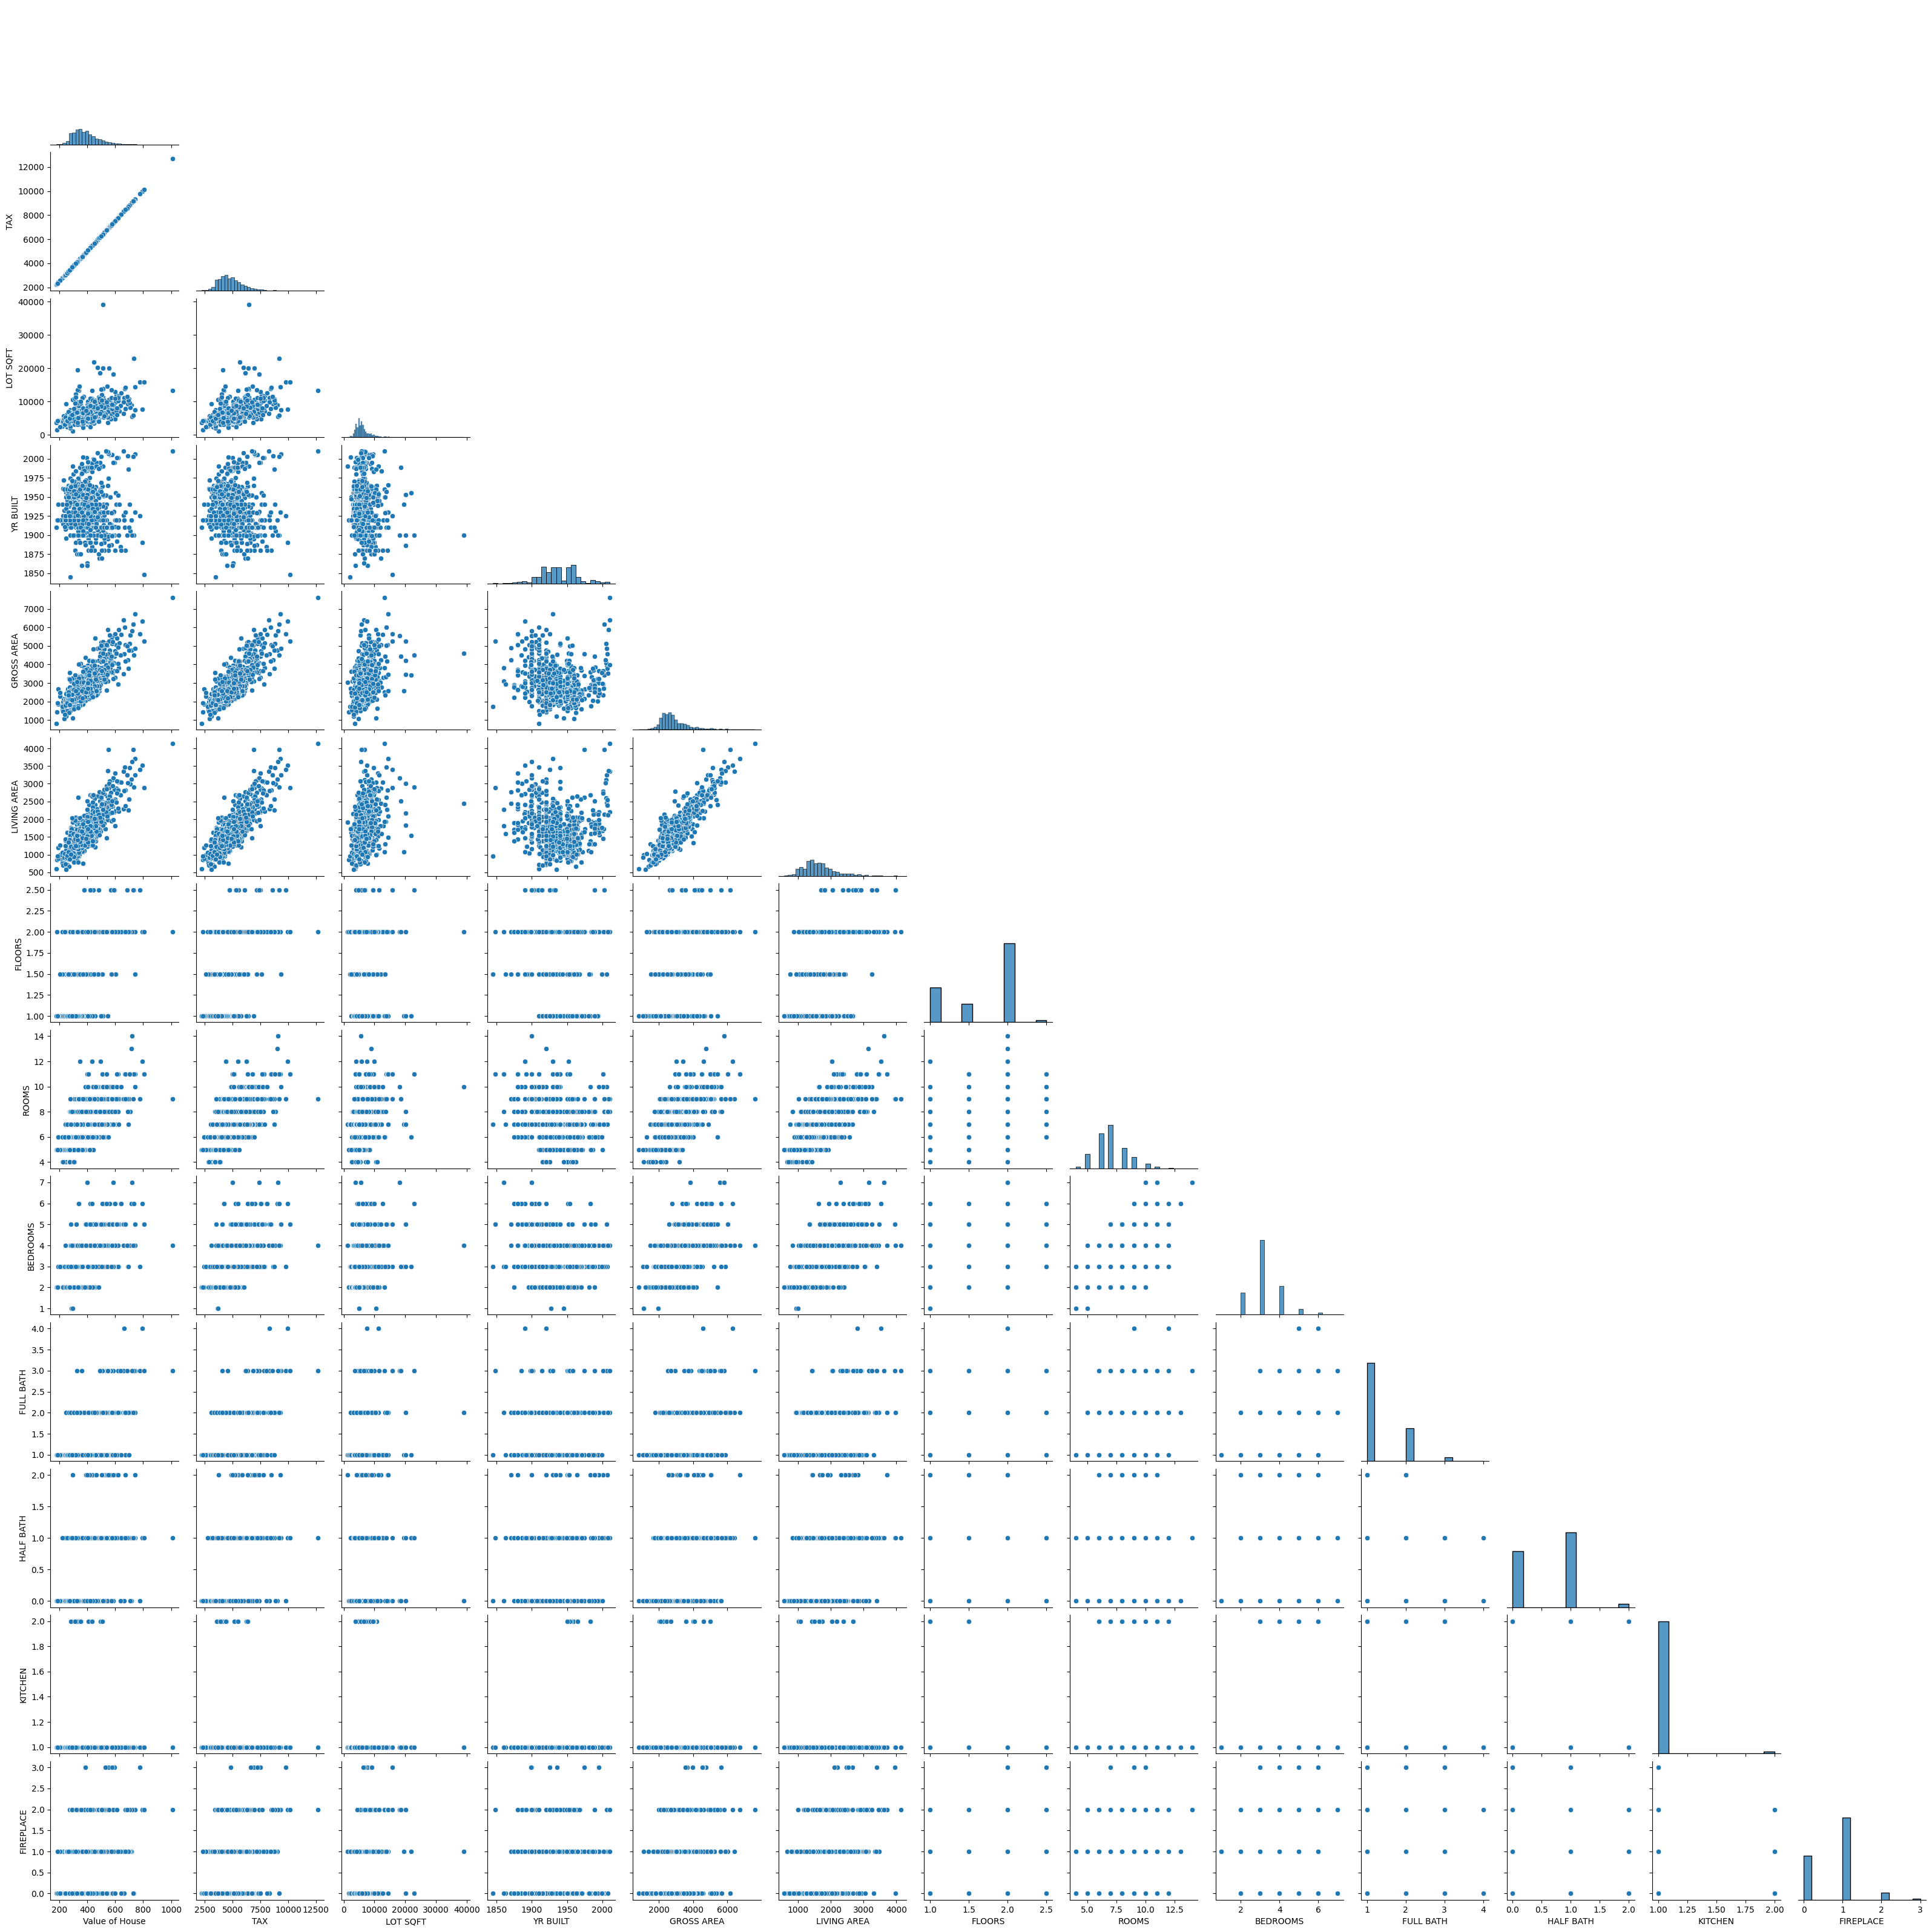

In [226]:
sns.pairplot(dff, corner = True)

<Axes: xlabel='REMODEL', ylabel='Value of House'>

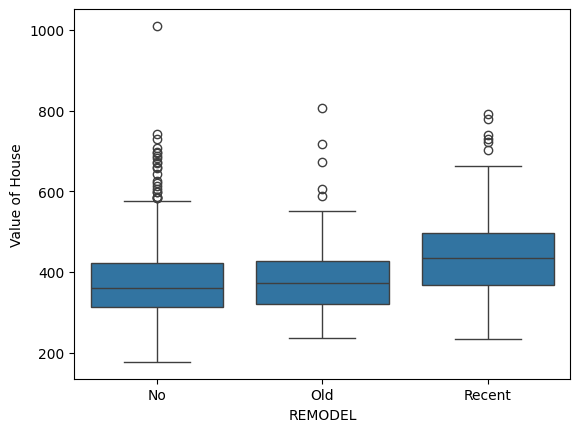

In [227]:
sns.boxplot(x = 'REMODEL', y = 'Value of House', data = df)

<Axes: xlabel='KITCHEN', ylabel='Value of House'>

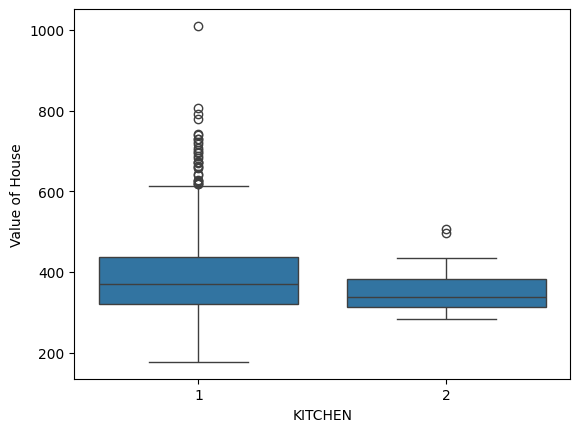

In [228]:
sns.boxplot(x = 'KITCHEN', y = 'Value of House', data = df)

'YR BUILT' has almost no correlation with the target 'Value of House'. 

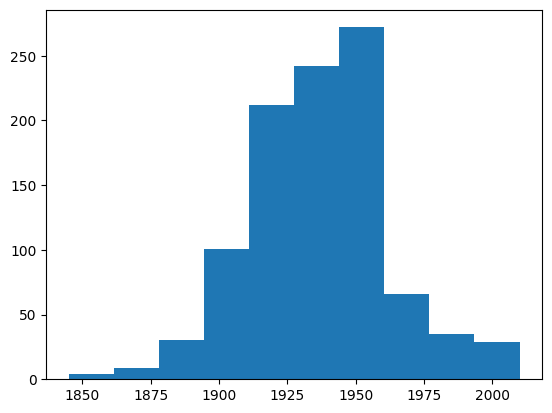

In [229]:
dff['YR BUILT'].hist()
plt.grid(False)

<Axes: >

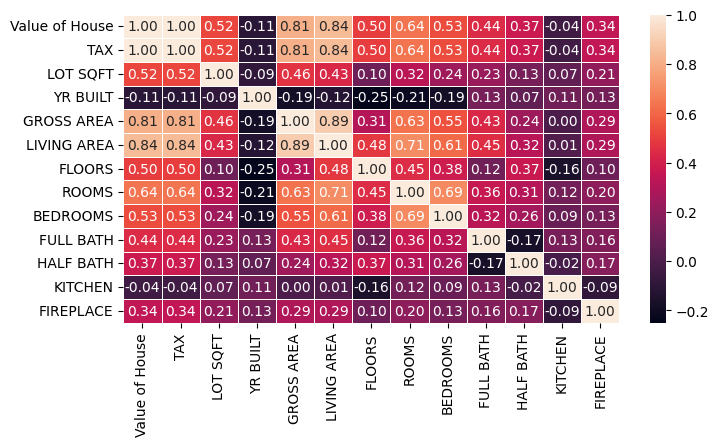

In [230]:
plt.figure(figsize = (8, 4))
sns.heatmap(dff.corr(method = 'pearson'), annot = True, fmt = '.2f', linewidths = 0.5)  #default

>> TAX is linearly and positively most correlated with the value/price of house.

<Axes: >

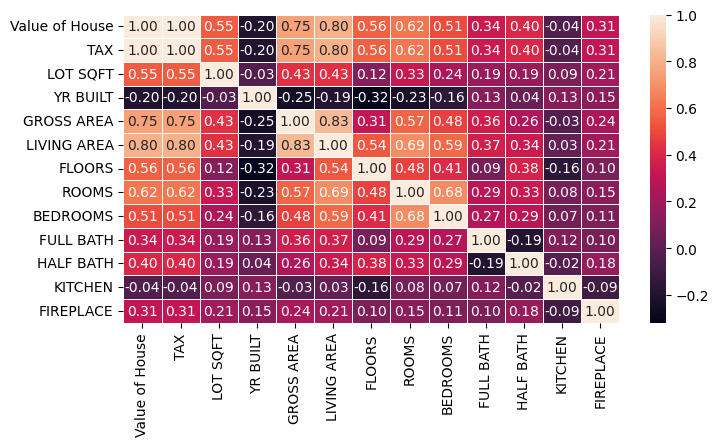

In [231]:
plt.figure(figsize = (8, 4))
sns.heatmap(dff.corr(method = 'spearman'), annot = True, fmt = '.2f', linewidths = 0.5) #rank correlation

# Feature Engineering

>> Get the dummy variables for REMODEL, this feature has more than 2 categories.

In [232]:
model = pd.get_dummies(df['REMODEL'])
model.head()

,No,Old,Recent
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,False,True,False


In [233]:
model = pd.get_dummies(df['REMODEL'], drop_first = True)
df = pd.concat([df, model], axis = 1)

> Data preprocessing like handling missing data, encoding categorical (variables) features done before feature selection.

In [ ]:
df.drop(['id', 'REMODEL', 'YR BUILT'], axis = 1, inplace = True)  #dropping 'YR BUILT' by correlation analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Value of House  1000 non-null   float64
 1   TAX             1000 non-null   int64  
 2   LOT SQFT        1000 non-null   int64  
 3   GROSS AREA      1000 non-null   int64  
 4   LIVING AREA     1000 non-null   int64  
 5   FLOORS          1000 non-null   float64
 6   ROOMS           1000 non-null   int64  
 7   BEDROOMS        1000 non-null   int64  
 8   FULL BATH       1000 non-null   int64  
 9   HALF BATH       1000 non-null   int64  
 10  KITCHEN         1000 non-null   int64  
 11  FIREPLACE       1000 non-null   int64  
 12  Old             1000 non-null   bool   
 13  Recent          1000 non-null   bool   
dtypes: bool(2), float64(2), int64(10)
memory usage: 95.8 KB


>> One of the categories (first) becomes redundant in 'REMODEL' if the other two are known.

In [235]:
df.head(5)

,Value of House,TAX,LOT SQFT,GROSS AREA,LIVING AREA,FLOORS,ROOMS,BEDROOMS,FULL BATH,HALF BATH,KITCHEN,FIREPLACE,Old,Recent
0,287.2,3612,6750,2344,1000,1.0,5,2,1,0,1,1,False,False
1,360.3,4532,4500,2680,1200,1.0,6,3,1,1,1,1,False,False
2,413.9,5206,7875,4203,2408,2.0,8,4,2,0,1,0,False,False
3,330.2,4153,7092,2778,1270,1.0,7,3,1,0,1,1,False,False
4,380.1,4781,3244,2616,1598,2.0,8,4,2,0,1,0,True,False


<Axes: xlabel='Value of House', ylabel='Count'>

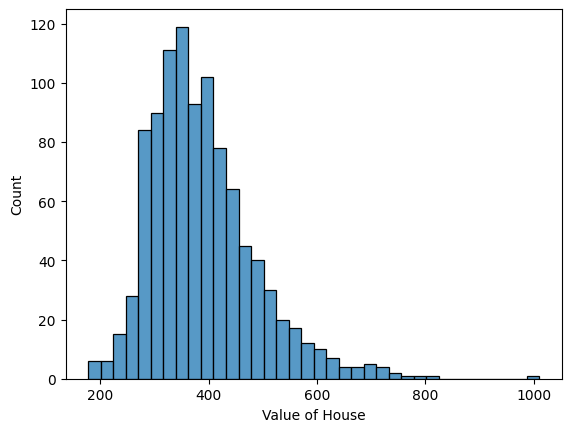

In [236]:
sns.histplot(df['Value of House'])

In [ ]:
#df.to_csv('processed_data.csv', index = False)

> Scale changes of the variables only affect the intercepts and not the slopes if there's no multiplicative term in the form of (variable) interaction.

>> Interaction terms with features 'rooms' and/or 'bedrooms' could be included and their impacts on the value of house could be investigated. The effect might or might not be statistically significant.  

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Value of House  1000 non-null   float64
 1   TAX             1000 non-null   int64  
 2   LOT SQFT        1000 non-null   int64  
 3   GROSS AREA      1000 non-null   int64  
 4   LIVING AREA     1000 non-null   int64  
 5   FLOORS          1000 non-null   float64
 6   ROOMS           1000 non-null   int64  
 7   BEDROOMS        1000 non-null   int64  
 8   FULL BATH       1000 non-null   int64  
 9   HALF BATH       1000 non-null   int64  
 10  KITCHEN         1000 non-null   int64  
 11  FIREPLACE       1000 non-null   int64  
 12  Old             1000 non-null   bool   
 13  Recent          1000 non-null   bool   
dtypes: bool(2), float64(2), int64(10)
memory usage: 95.8 KB


In [238]:
num_vars = ['TAX', 'LOT SQFT', 'GROSS AREA', 'LIVING AREA', 'FLOORS', 'ROOMS',
            'BEDROOMS', 'FIREPLACE', 'KITCHEN']

scaler = MinMaxScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

>> This is to ensure all variables in the dataset are at a comparable scale.

In [239]:
df.dtypes

,0
Value of House,float64
TAX,float64
LOT SQFT,float64
GROSS AREA,float64
LIVING AREA,float64
FLOORS,float64
ROOMS,float64
BEDROOMS,float64
FULL BATH,int64
HALF BATH,int64


In [240]:
df.head(5)

,Value of House,TAX,LOT SQFT,GROSS AREA,LIVING AREA,FLOORS,ROOMS,BEDROOMS,FULL BATH,HALF BATH,KITCHEN,FIREPLACE,Old,Recent
0,287.2,0.131863,0.145989,0.223872,0.119202,0.000000,0.1,0.166667,1,0,0.0,0.333333,False,False
1,360.3,0.219708,0.086407,0.273262,0.175429,0.000000,0.2,0.333333,1,1,0.0,0.333333,False,False
2,413.9,0.284064,0.175781,0.497134,0.515041,0.666667,0.4,0.500000,2,0,0.0,0.000000,False,False
3,330.2,0.183520,0.155046,0.287667,0.195108,0.000000,0.3,0.333333,1,0,0.0,0.333333,False,False
4,380.1,0.243483,0.053147,0.263854,0.287321,0.666667,0.4,0.500000,2,0,0.0,0.000000,True,False


In [ ]:
#df.to_csv('processed_scaled_data.csv', index = False)

> Feature scaling or normalization or standardization must ideally be on train dataset.

In [241]:
X = df.drop('Value of House', axis = 1)    #independent variables

In [242]:
Y = df['Value of House']    #dependent variable

> Checking for multicollinearity of independent variables: VIF is a diagnostic tool for detecting multicollinearity

>> For more on multicollinearity: https://www.linkedin.com/pulse/what-multicollinearity-visual-description-karen-grace-martin-zao1c/

In [243]:
X = X.astype(float)
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,GROSS AREA,37.507313
3,LIVING AREA,37.317743
0,TAX,27.949953
5,ROOMS,14.744858
6,BEDROOMS,14.428305
7,FULL BATH,8.961793
1,LOT SQFT,6.008515
4,FLOORS,5.674154
8,HALF BATH,3.189797
10,FIREPLACE,2.989155


>> [TAX, GROSS AREA, LIVING AREA, ROOMS, BEDROOMS]

> Data splitting into train and test sets ⬇⬇

>> For imbalanced data, resampling is done for faithful representation of target classes, but resampling must ideally be done on train dataset only.

>> For imbalanced data, feature selection must also be done after resampling.

In [244]:
np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

> 70% is chosen to be the subset on which the model shall be trained.

In [ ]:
#train = pd.concat([x_train, y_train], axis = 1)
#train.to_csv('train_data.csv', index = False)

#test = pd.concat([x_test, y_test], axis = 1)
#test.to_csv('test_data.csv', index = False)

>> Data splitting into train and test sets  ensures unbiased model evaluation on test dataset which is assumed to be the closest to new data the model sees (in production) and hence, avoids data leakage.

> Recursive Feature Elimination (RFE) - just checking with scikit learn

In [245]:
lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(lm)
rfe.fit(x_train, y_train)

list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('TAX', np.True_, np.int64(1)),
 ('LOT SQFT', np.False_, np.int64(6)),
 ('GROSS AREA', np.True_, np.int64(1)),
 ('LIVING AREA', np.True_, np.int64(1)),
 ('FLOORS', np.False_, np.int64(8)),
 ('ROOMS', np.True_, np.int64(1)),
 ('BEDROOMS', np.True_, np.int64(1)),
 ('FULL BATH', np.False_, np.int64(5)),
 ('HALF BATH', np.False_, np.int64(4)),
 ('KITCHEN', np.True_, np.int64(1)),
 ('FIREPLACE', np.False_, np.int64(3)),
 ('Old', np.False_, np.int64(2)),
 ('Recent', np.False_, np.int64(7))]

>> https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [246]:
col = x_train.columns[rfe.support_]
print(col)

Index(['TAX', 'GROSS AREA', 'LIVING AREA', 'ROOMS', 'BEDROOMS', 'KITCHEN'], dtype='object')


>> One can train the model with these 6 selected features only.

In [ ]:
#X_train_rfe = X_train[col]

> **We go ahead and fit a regression equation with all 13 independent features.**

# Model

In [247]:
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train.astype(float))
results = model.fit()
print(results.summary(alpha = 0.05))

                            OLS Regression Results                            
Dep. Variable:         Value of House   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.173e+09
Date:                Fri, 11 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:06:57   Log-Likelihood:                 1692.3
No. Observations:                 700   AIC:                            -3357.
Df Residuals:                     686   BIC:                            -3293.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         177.3835      0.003   5.47e+04      

In [248]:
results.pvalues

,0
const,0.000000
TAX,0.000000
LOT SQFT,0.931706
GROSS AREA,0.165389
LIVING AREA,0.406391
FLOORS,0.997136
ROOMS,0.001771
BEDROOMS,0.024979
FULL BATH,0.395848
HALF BATH,0.105972


>> Variables with p-value less than 0.05 are statistically significant.

>> [TAX, ROOMS, BEDROOMS, Old_REMODEL]

In [249]:
results.params    ##weights or coefficients

,0
const,177.383513
TAX,832.506894
LOT SQFT,-0.001158
GROSS AREA,0.023283
LIVING AREA,-0.013951
FLOORS,0.000014
ROOMS,0.030024
BEDROOMS,-0.019257
FULL BATH,-0.001686
HALF BATH,-0.003067


>> [TAX, ROOMS, GROSS AREA]

In [250]:
res = results.get_prediction().summary_frame(alpha = 0.05)  #default
res

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
541,367.687724,0.003950,367.679969,367.695479,367.644250,367.731199
440,385.893046,0.004463,385.884283,385.901808,385.849380,385.936711
482,312.996401,0.002357,312.991774,313.001029,312.953374,313.039428
422,393.833756,0.002811,393.828237,393.839276,393.790625,393.876888
778,340.024024,0.002764,340.018597,340.029451,339.980904,340.067144
...,...,...,...,...,...,...
106,307.117001,0.004895,307.107390,307.126613,307.073158,307.160845
270,480.402474,0.002140,480.398273,480.406675,480.359491,480.445457
860,272.931219,0.003133,272.925068,272.937370,272.888002,272.974436
435,408.706670,0.001698,408.703336,408.710003,408.663763,408.749576


In [251]:
results.fittedvalues  #mean value

,0
541,367.687724
440,385.893046
482,312.996401
422,393.833756
778,340.024024
...,...
106,307.117001
270,480.402474
860,272.931219
435,408.706670


# Predictions on test data

In [252]:
x_test = sm.add_constant(x_test)
re = results.get_prediction(x_test.astype(float)).summary_frame(alpha = 0.05)
re

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
521,500.036722,0.002017,500.032762,500.040682,499.993762,500.079682
737,356.397094,0.003532,356.390158,356.404029,356.353758,356.440430
740,393.207229,0.002708,393.201913,393.212545,393.164123,393.250335
660,320.791879,0.003282,320.785435,320.798322,320.748619,320.835139
411,404.494425,0.002375,404.489763,404.499088,404.451395,404.537456
...,...,...,...,...,...,...
468,422.611192,0.001757,422.607742,422.614641,422.568275,422.654108
935,311.162529,0.003632,311.155399,311.169660,311.119162,311.205897
428,389.310681,0.002076,389.306605,389.314757,389.267710,389.353652
7,395.666392,0.001579,395.663291,395.669493,395.623502,395.709281


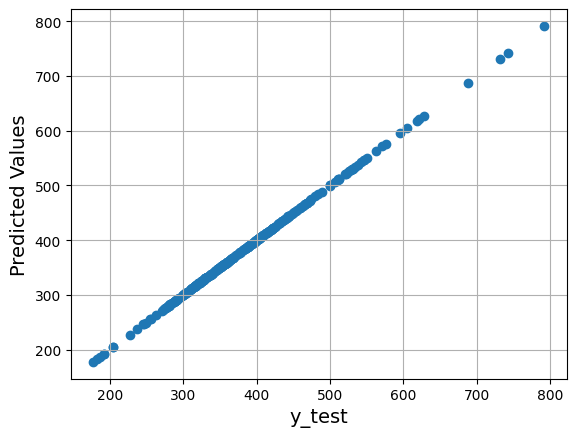

In [253]:
linreg_y_pred = results.predict(x_test)
residuals = (y_test - linreg_y_pred)

fig = plt.figure()
plt.scatter(y_test, linreg_y_pred)
fig.suptitle('', fontsize = 20)
plt.xlabel('y_test', fontsize = 14)
plt.ylabel('Predicted Values', fontsize = 14)
#print("R^2=", round(r2_score(y_test, linreg_y_pred), 4))
plt.grid(True)

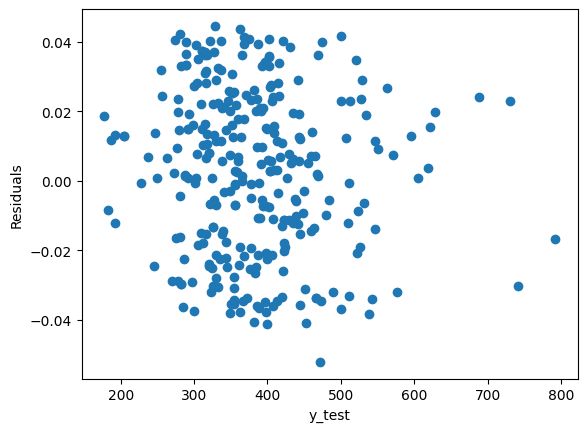

In [254]:
plt.scatter(y_test, residuals)
plt.xlabel('y_test')
plt.ylabel('Residuals')
plt.show()

/tmp/ipython-input-255-2392964184.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins = 20, kde = True, label = 'Residual plot')   #alpha = 0.5


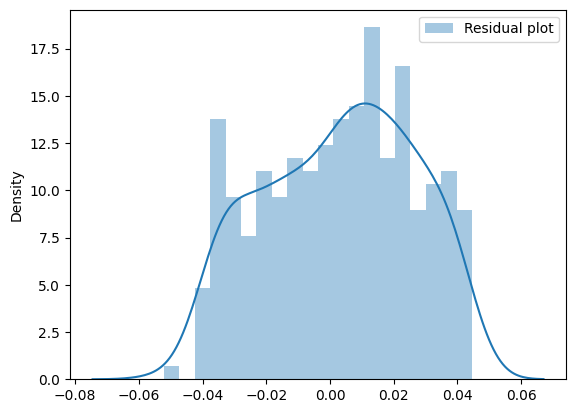

In [255]:
sns.distplot(residuals, bins = 20, kde = True, label = 'Residual plot')
plt.legend()

In [ ]:
#plt.plot(y_test, '.')
#plt.errorbar(y_test, re['mean'], xerr = re['mean_se'], fmt = '.', color = 'green', ecolor = 'red', capsize = 9.0)

#plt.title('Fitted values with standard errors')
#plt.xlabel(y_test)
#plt.ylabel('Fitted values')
#plt.show()

In [ ]:
#plt.plot(y_test, '.')
#plt.plot(y_test, re['mean'], 'o')
#plt.plot(y_test, re['obs_ci_lower'], 'g-', lw = 1.0)
#plt.plot(y_test, re['obs_ci_upper'], 'g-', lw = 1.0)

#plt.xlabel('y_test')
#plt.ylabel('Fitted values')
#plt.show()

In [ ]:
#plt.plot(y_test, '.')
#plt.plot(y_test, re['mean'], 'o')
#plt.plot(y_test, re['mean_ci_lower'], 'r-', lw = 1.0)
#plt.plot(y_test, re['mean_ci_upper'], 'r-', lw = 1.0)

#plt.xlabel('y_test')
#plt.ylabel('Fitted values')
#plt.show()

# Checks for how the algorithm functions - methods

In [259]:
#print(wls_prediction_std(results))
preds_std, CI_lower, CI_upper = wls_prediction_std(results)

**Lower the standard deviation, narrower is the interval.**

In [260]:
#print(summary_table(results, alpha = 0.05))
st, data, cols = summary_table(results, alpha = 0.05)

In [261]:
fitted = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_lower, predict_mean_ci_upper = data[:, 4:6].T
predict_ci_lower, predict_ci_upper = data[:, 6:8].T

In [262]:
print(np.max(np.abs(results.fittedvalues - fitted)))
print(np.max(np.abs(CI_lower - predict_ci_lower)))
print(np.max(np.abs(CI_upper - predict_ci_upper)))

0.0
0.0
0.0


In [263]:
#print(np.max(np.abs(res['mean'] - fitted)))
print(np.max(np.abs(res['obs_ci_lower'] - predict_ci_lower)))
print(np.max(np.abs(res['obs_ci_upper'] - predict_ci_upper)))

0.0
0.0


In [ ]:
#plt.plot(y_train, '.')
#plt.plot(y_train, fitted, 'o', lw = 1.0)
#plt.plot(y_train, predict_ci_lower, 'g--', lw = 1.0)
#plt.plot(y_train, predict_ci_upper, 'g--', lw = 1.0)

#plt.xlabel('y_train')
#plt.show()

In [ ]:
#plt.plot(y_train, '.')
#plt.plot(y_train, fitted, 'o', lw = 1.0)
#plt.plot(y_train, predict_mean_ci_lower, 'g--', lw = 1.0)
#plt.plot(y_train, predict_mean_ci_upper, 'g--', lw = 1.0)

#plt.xlabel('y_train')
#plt.show()

>> **Prediction interval is the confidence interval for an observation and includes the standard error in estimation for statsmodels OLS.**

> A **confidence interval** is the range that yields some level of confidence, to contain the true value of a population parameter, such as the population mean.

> A **prediction interval** is the range that is expected with some level of confidence, to contain the true value of an individual data point, based on a prediction made using regression analysis.>

> "The true value of the population parameter is usually not exactly equal to the value estimated from the sample and the difference is the standard error. To account for this error, it is conventional to estimate a value and specify a range that is expected to contain the actual value."

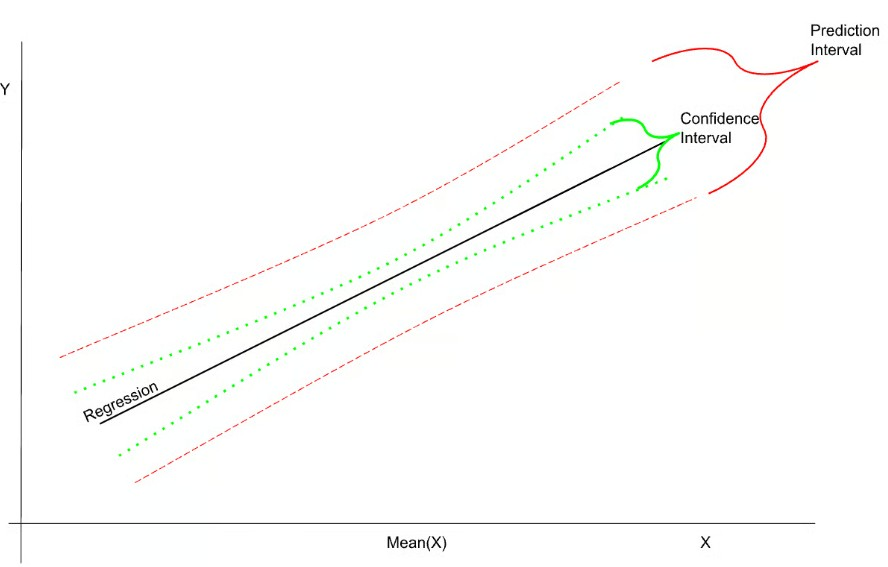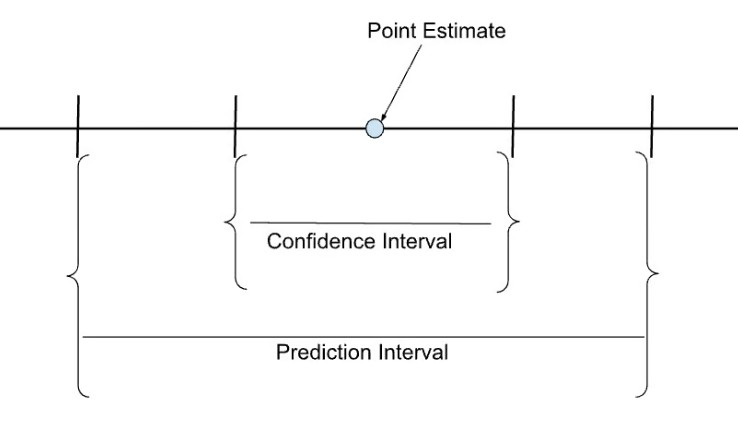

> https://www.datacamp.com/blog/confidence-intervals-vs-prediction-intervals


> Features selected by correlation analysis while exploring data

> Features predicted from the fitted model (statsmodels, scikit-learn):

>> By coefficients-> [TAX, GROSS AREA, ROOMS]

>> By p-values-> [TAX, ROOMS, BEDROOMS, Old_REMODEL]

>> By RFE-> [TAX, GROSS AREA, LIVING AREA, ROOMS, BEDROOMS, KITCHEN]

> And then there're (predictors) features selected by VIF (values typically higher than 10 have multicollinearity).


Well, the target is 'value of house' which is predicted using OLS on 13 explanatory features ->   
[TAX, GROSS AREA, LIVING AREA, ROOMS, BEDROOMS, KITCHEN, FULL BATH, HALF BATH, FIREPLACE, Old_REMODEL, Recent_REMODEL, LOT SQFT, FLOORS]


 

>>